In [9]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


In [10]:
train = pd.read_csv('preprocessed_train.csv')
test = pd.read_csv('preprocessed_test.csv')

# remove last event for each case in order to not break the model when accessing the next event time + make predictions on seconds_next + do tuning (grid search, feature selection) and cv


# Evaluation


In [11]:
def time_evaluation(y_test, y_pred, model: str):
 
    print(f"Error metrics (measured in hours) for the {model} when predicting the next event's Unix timestamp")
    print('\n')
    print('Mean Absolute Error:', round(mean_absolute_error(y_test, y_pred)/3600,3))
    print('Root Mean Squared Error:', round(np.sqrt(mean_squared_error(y_test, y_pred)/3600),3))
    print('R2 score:', round(r2_score(y_test, y_pred),3))
    
    
def event_evaluation(y_test, y_pred, model: str, avg="weighted"):

    precision = precision_score(y_test, y_pred, average=avg, zero_division=0)
    recall = recall_score(y_test, y_pred, average=avg, zero_division=0)
    F1_score = f1_score(y_test, y_pred, average=avg, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f'Error metrics for the {model} when predicting the next event')
    print('\n')
    print(f'Accuracy: {round(accuracy,3)}.')
    print(f'Precision: {round(precision,3)}')
    print(f'Recall: {round(recall,3)}')
    print(f'f1-score: {round(F1_score,3)}')
#     print(confusion_matrix(y_test, y_pred))

# Data splitting and encoding

In [12]:
def encoder(df):
    """
    encode the columns that are needed in the models
    """
    event_encoder = LabelEncoder()

    events = df["event concept:name"].unique().tolist() + ['FIRST EVENT',"LAST EVENT"]
    event_encoder.fit(events)
    
    df[["event concept:name","prev_event", "2prev_event", 'next_event']] = df[["event concept:name", 
            "prev_event", "2prev_event", 'next_event']].apply(event_encoder.transform)
    
    return df

In [13]:
train = encoder(train)
test = encoder(test)

In [ ]:
train2 = train
test2 = test

train2['next position'] = train2.groupby('case concept:name')['position'].shift(-1) #Creates new column with NaN values for the last even in a case
test2['next position'] = test2.groupby('case concept:name')['position'].shift(-1)

train2 = train2.dropna(subset=['next position']) #Drop all last events per case
test2 = test2.dropna(subset=['next position'])

In [15]:
X_train = train2[['event concept:name','prev_event', '2prev_event', 'seconds_prev', 'timestamp_finish']]
y_train = train2[['next_event', 'seconds_next']]

X_test = test2[['event concept:name','prev_event', '2prev_event', 'seconds_prev', 'timestamp_finish']]
y_test = test2[['next_event', 'seconds_next']]

# select only 'next_timestamp' for predicting time and 'next_event' for events

# Event prediction

In [8]:
def RandomForestEvents(X_train, X_test, y_train, y_test):
    '''no grid search, no cv, or feature selection, do for final model
    '''
    
    X_train_event = X_train[['event concept:name','prev_event', '2prev_event']]
    y_train_event = y_train['next_event']

    X_test_event = X_test[['event concept:name','prev_event', '2prev_event']]
    y_test_event = y_test['next_event']
    
    forest_clf = RandomForestClassifier(n_estimators=10, bootstrap = False, criterion = 'gini', random_state=42)
    forest_clf.fit(X_train_event, y_train_event)
    
    y_pred = forest_clf.predict(X_test_event)

    return forest_clf, y_pred

In [9]:
forest_event, y_pred_event = RandomForestEvents(X_train, X_test, y_train, y_test)

In [10]:
event_evaluation(y_test['next_event'], y_pred_event, 'Random forest classifier')

Error metrics for the Random forest classifier when predicting the next event


Accuracy: 0.785.
Precision: 0.772
Recall: 0.785
f1-score: 0.748


In [11]:
forest_event.feature_importances_
# current + prev 2 events are all important

array([0.39591211, 0.32614465, 0.27794324])

# Time prediction

In [16]:
def RandomForestTime(X_train, X_test, y_train, y_test):
    '''no grid search, no cv, or feature selection, do for final model
    '''
    
    X_train_time = X_train[['event concept:name','prev_event', '2prev_event', 'seconds_prev', 'timestamp_finish']]
    y_train_time = y_train['seconds_next']



    X_test_time = X_test[['event concept:name','prev_event', '2prev_event', 'seconds_prev', 'timestamp_finish']]
    y_test_time = y_test['seconds_next']
    
    forest_reg = RandomForestRegressor(n_estimators=10, bootstrap = False, random_state=42)
    forest_reg.fit(X_train_time, y_train_time)
    
    y_pred = forest_reg.predict(X_test_time)

    return forest_reg, y_pred

In [18]:
forest_time, y_pred_time = RandomForestTime(X_train, X_test, y_train, y_test)

In [19]:
time_evaluation(y_test['seconds_next'], y_pred_time, 'Random forest regressor')

Error metrics (measured in hours) for the Random forest regressor when predicting the next event's Unix timestamp


Mean Absolute Error: 14.198
Root Mean Squared Error: 2764.311
R2 score: 0.015


In [15]:
forest_time.feature_importances_
# only the time of prev event seems to be important, great r2 score

array([0.00384918, 0.00481503, 0.0045932 , 0.00854127, 0.97820133])

## Time, Memory and CPU usage

### Memory and CPU usage

In [24]:
import psutil
import time

# start measuring CPU and memory usage
process = psutil.Process()

# start point
start_time = time.time()

forest_event, y_pred_event = RandomForestEvents(X_train, X_test, y_train, y_test)
event_evaluation(y_test['next_event'], y_pred_event, 'Random forest classifier')
forest_time, y_pred_time = RandomForestTime(X_train, X_test, y_train, y_test)
time_evaluation(y_test['next_timestamp'], y_pred_time, 'Random forest regressor')
# end point
end_time = time.time()

# calculate time taken
elapsed_time = end_time - start_time
print(f"Time taken: {elapsed_time:.2f} seconds")

# measure CPU and memory usage
cpu_usage = process.cpu_percent()
memory_usage = process.memory_info().rss / 1024 / 1024  # in MB
print(f"CPU usage: {cpu_usage:.2f}%")
print(f"Memory usage: {memory_usage:.2f} MB")

Error metrics for the Random forest classifier when predicting the next event


Accuracy: 0.785.
Precision: 0.772
Recall: 0.785
f1-score: 0.748
Error metrics (measured in hours) for the Random forest regressor when predicting the next event's Unix timestamp


Mean Absolute Error: 162.714
Root Mean Squared Error: 44633.469
R2 score: 0.929
Time taken: 9.46 seconds
CPU usage: 0.00%
Memory usage: 524.21 MB


### Time usage

In [18]:
start_time = time.time()

# RandomForestEvents function
forest_event, y_pred_event = RandomForestEvents(X_train, X_test, y_train, y_test)

# event_evaluation function
event_evaluation(y_test['next_event'], y_pred_event, 'Random forest classifier')

print(f"Time taken by RandomForestEvents: {time.time() - start_time} seconds")

start_time = time.time()

# RandomForestTime function
forest_time, y_pred_time = RandomForestTime(X_train, X_test, y_train, y_test)

# time_evaluation function
time_evaluation(y_test['next_timestamp'], y_pred_time, 'Random forest regressor')

print(f"Time taken by RandomForestTime: {time.time() - start_time} seconds")

Error metrics for the Random forest classifier when predicting the next event


Accuracy: 0.785.
Precision: 0.772
Recall: 0.785
f1-score: 0.748
Time taken by RandomForestEvents: 0.6969540119171143 seconds
Error metrics (measured in hours) for the Random forest regressor when predicting the next event's Unix timestamp


Mean Absolute Error: 162.714
Root Mean Squared Error: 44633.469
R2 score: 0.929
Time taken by RandomForestTime: 8.802412033081055 seconds


# Visualizations

### Confusion matrix for Random Forest estimator

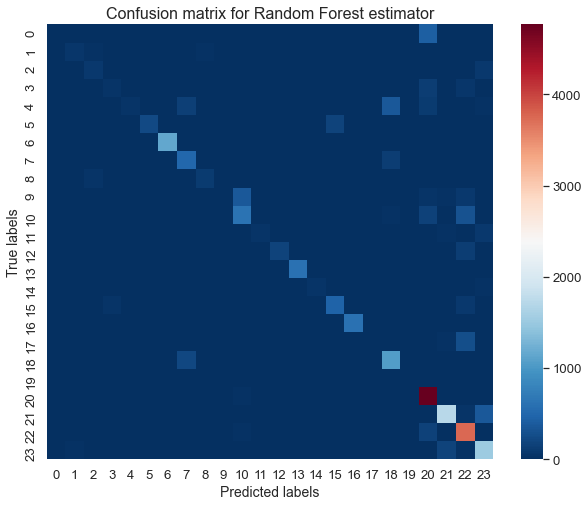

In [15]:
cm = confusion_matrix(y_test['next_event'], y_pred_event)

# plot confusion matrix as a heatmap
sns.set(font_scale=1.2)
fig, ax = plt.subplots(figsize=(10,8), facecolor='w')  # add facecolor attribute
sns.heatmap(cm, fmt='g', cmap='RdBu_r', ax=ax, annot_kws={"size": 14})
ax.set_xlabel('Predicted labels', fontsize=14)
ax.set_ylabel('True labels', fontsize=14)
ax.set_title('Confusion matrix for Random Forest estimator', fontsize=16)
plt.show()

### Naive and Random Forest estimators accuracy and precision

In [16]:
# plot the naive and random forest f1, acc, pre, recall
metrics_df = pd.DataFrame({
    ' ': ['F1 Score', 'Accuracy', 'Precision', 'Recall'],
    'Naive': ['0.266', '0.346', '0.297', '0.346'],
    'Random Forest': ['0.748', '0.785', '0.772', '0.785']    
})

metrics_df.to_string(index=False)
metrics_df

,,Naive,Random Forest
0,F1 Score,0.266,0.748
1,Accuracy,0.346,0.785
2,Precision,0.297,0.772
3,Recall,0.346,0.785


### Bar chart for feature importance of Random Forest event estimator

In [20]:
import matplotlib.pyplot as plt

# get feature importances and their names
importances = forest_event.feature_importances_
# feature_names = X_train.columns.values
feature_names = ['Current event', 'Previous event', '2nd previous event']

# sort the features by importance in descending order
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]

plt.figure(figsize=(10,6))
plt.bar(feature_names, sorted_importances, color=['brown', 'green', 'blue'])
plt.title('Feature Importances of Random Forest event estimator')
plt.xlabel('Features')
plt.xticks(rotation=0)
plt.ylabel('Importance')
plt.show()


NameError: name 'forest_event' is not defined

### Bar chart feature importance Random Forest time estimator

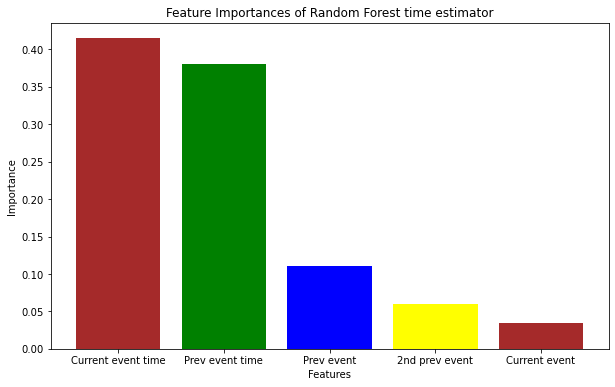

In [21]:
# get feature importances and their names
importances = forest_time.feature_importances_
feature_names = ['Current event time','Prev event time', 'Prev event', '2nd prev event', 'Current event']

# sort the features by importance in descending order
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]

plt.figure(figsize=(10,6))
plt.bar(feature_names, sorted_importances, color=['brown', 'green', 'blue', 'yellow'])
plt.title('Feature Importances of Random Forest time estimator')
plt.xlabel('Features')
plt.xticks(rotation=0)
plt.ylabel('Importance')
plt.show()

<AxesSubplot:xlabel='real', ylabel='error'>

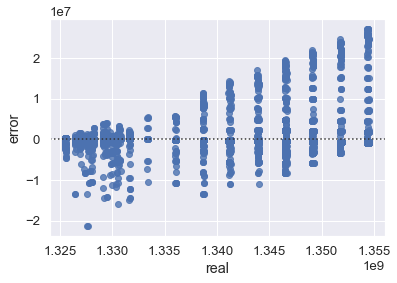

In [19]:
residual = pd.concat([y_test, pd.Series(y_pred_time)], axis="columns", ignore_index=True)
residual.columns = ['none','real','pred']
residual['error']= residual['real']-residual['pred']

sns.residplot(x='real', y='error', data=residual)
